In [1]:
'''
Title: Variational Autoencoder
This code has been written in reference to code in Keras code examples.
'''
#import libraries
import tensorflow as tf
import numpy as np
from tensorflow.keras import Model, layers
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Reshape, Conv2DTranspose
import matplotlib.pyplot as plt

# Load and prepare the dataset

In [2]:
(x_train, y_train),(x_test,y_test) = tf.keras.datasets.mnist.load_data()

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train.shape


(60000, 28, 28, 1)

# Defining the Model and adding loss functions

In [9]:
class VAE(Model):
    class Sampling(layers.Layer):
        def call(self, inputs):
            z_mean, z_log_var = inputs
            epsilon = tf.keras.backend.random_normal(shape=tf.shape(z_mean))
            return z_mean + tf.exp(0.5* z_log_var) * epsilon
    
    def __init__(self, img_shape, latent_dim, summary = True, **kwargs):
        super(VAE, self).__init__(**kwargs)
        
        
        '''Defining encoder model'''
        inputs = tf.keras.Input(shape= img_shape)
        x = Conv2D(16, 3, activation="relu", strides=2, padding="same")(inputs)
        x = Flatten()(x)
        x = Dense(128, activation="relu")(x)
        mean = Dense(latent_dim, name="mean")(x)
        log_var = Dense(latent_dim, name="log_var")(x)
        
        #reparameterisation trick(sampling from a random distribution)
        sampled = self.Sampling()([mean, log_var])
        
        #create encoder model
        self.encoder = Model(inputs, [sampled,mean,log_var], name = "Encoder")
        
        
        '''Defining decoder model'''
        latent_input = tf.keras.Input(shape= (latent_dim))
        y = Dense(128, activation="relu")(latent_input)
        y = Dense(14*14*16, activation="relu")(y)
        y = Reshape((14,14,16))(y)
        output = Conv2DTranspose(1, 3, activation="relu", strides=2, padding="same")(y)
#         output = Dense(784, activation="relu")(y)
#         output = Reshape(img_shape)(y)
        
        #create decoder model
        self.decoder = Model(latent_input, output, name = "Decoder")
        
        # create Variational Autoencoder
        encoded, mean, log_var = self.encoder(inputs)
        decoded = self.decoder(encoded)
        self.vae_model = Model(inputs, decoded, name = "VAE")
        
        
        #creating the 3 loss trackers
        self.total_loss_tracker = tf.keras.metrics.Mean(name="loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="recon_loss")
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")
        
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

    
    @property
    def metrics(self):
        return [ self.total_loss_tracker, self.reconstruction_loss_tracker, self.kl_loss_tracker]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            encoded, mean, log_var = self.encoder(data)
            decoded = self.decoder(encoded)
            recon_loss = tf.reduce_sum(tf.keras.losses.binary_crossentropy(data, decoded), axis =(1, 2))
            recon_loss = tf.reduce_mean(recon_loss)
            kl_loss = -0.5 * (1 + log_var - tf.square(mean) - tf.exp(log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = recon_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(recon_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return { m.name : m.result() for m in self.metrics}

# Obtain the models
Encoder, Decoder and Variational Autoencoder

In [10]:
latent_dim = 2
img_shape = (28,28,1)

vae = VAE(img_shape, latent_dim)


vae.encoder.summary()
vae.decoder.summary()
vae.vae_model.summary()

Model: "Encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 16)   160         input_7[0][0]                    
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 3136)         0           conv2d_3[0][0]                   
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 128)          401536      flatten_3[0][0]                  
____________________________________________________________________________________________

In [11]:
# def loss_function(mean, variance):
#     def total_loss(y_true, y_pred):
#         reconstruction_loss = tf.keras.losses.mse(y_true, y_pred)
#         reconstruction_loss_batch = tf.reduce_mean(reconstruction_loss)*28*28

#         kl_loss = 1 + variance - tf.square(mean) - tf.exp(variance)
#         kl_loss_batch = tf.reduce_mean(kl_loss)*(-0.5)

#         return reconstruction_loss_batch + kl_loss_batch
    
#     return total_loss
    
# inputs = tf.keras.Input(shape= img_shape)
# encoded, mean, log_var = vae.encoder()
# vae.compile(loss = loss_function(mean, log_var), optimizer = "adam")


In [12]:
vae.compile(optimizer='adam')

# Train the model
Using Learning Rate Scheduler

In [41]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='loss', 
                              factor=0.2,
                              patience=3, 
                              min_lr=0.001)

vae.fit(x_train,
        x_train,
        initial_epoch = 30,
        epochs = 40,
        batch_size = 64,
#         validation_data = (x_test, x_test),
        callbacks=[reduce_lr],
        )

Epoch 31/40
938/938 [==============================] - 6s 7ms/step - loss: 343.4123 - recon_loss: 336.5066 - kl_loss: 6.9060
Epoch 32/40
938/938 [==============================] - 6s 7ms/step - loss: 346.9837 - recon_loss: 340.2143 - kl_loss: 6.7696
Epoch 33/40
938/938 [==============================] - 7s 7ms/step - loss: 357.6273 - recon_loss: 350.8839 - kl_loss: 6.7432
Epoch 34/40
938/938 [==============================] - 7s 7ms/step - loss: 349.5886 - recon_loss: 342.9247 - kl_loss: 6.6636
Epoch 35/40
938/938 [==============================] - 7s 7ms/step - loss: 343.6113 - recon_loss: 336.7754 - kl_loss: 6.8357
Epoch 36/40
938/938 [==============================] - 7s 7ms/step - loss: 352.9369 - recon_loss: 346.3223 - kl_loss: 6.6149
Epoch 37/40
938/938 [==============================] - 7s 7ms/step - loss: 348.3254 - recon_loss: 341.4649 - kl_loss: 6.8605
Epoch 38/40
938/938 [==============================] - 7s 7ms/step - loss: 345.6848 - recon_loss: 338.7762 - kl_loss: 6.9089


# Visualize the Latent Space Distribution 

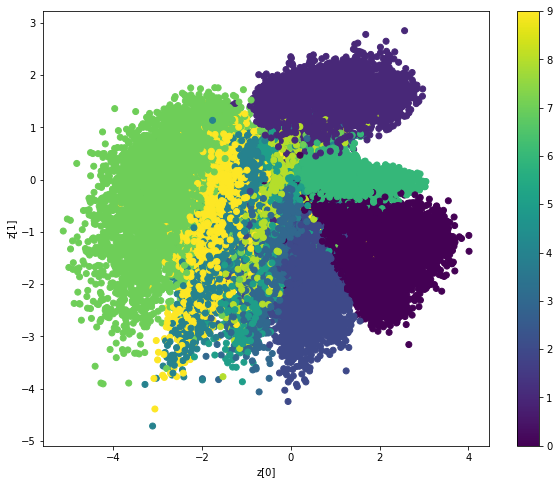

In [42]:
def plot_clusters( data, labels):
    # visualising the latent space
    mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(10, 8))
    
    mean_dim1 = mean[:,0]
    mean_dim2 = mean[:,1]
    plt.scatter(mean_dim1, mean_dim2, c=labels, linewidths = 1, edgecolors = None)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig("images/latent_space.png")
    plt.show()
    

# print(x_train.shape)

plot_clusters(x_train, y_train)

# Reconstructing Images

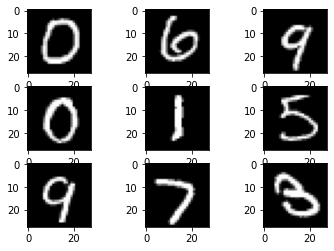

Real Images


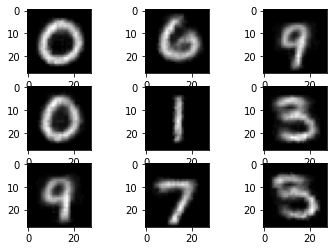

Reconstructed Images with VAE


In [43]:
flag=10
num = 9 #num should be less than 10
data = x_test[flag: num+flag]
output = vae.predict(data)*255

plt.figure()
for i in range(num):
    plt.subplot(330 + 1 + i)
    plt.imshow(data[i], cmap='gray')
plt.savefig("images/real_images.png")
plt.show()
print("Real Images")


for i in range(num):
    plt.subplot(330 + 1 + i)
    plt.imshow(output[i], cmap='gray')
plt.savefig("images/reconstructed Images.png")
plt.show()
print ("Reconstructed Images with VAE")

# Generating Images

In [44]:
def image_generator(num):
    a=3
    z1 = np.linspace(-a, a, num)
    z2 = np.linspace(-a, a, num)

    figure = np.zeros((28*num, 28*num))
    
    for i,x in enumerate(z1) :
        for j,y in enumerate(z2):
            generated_image = vae.decoder.predict([[x,y]])[0]
            image = generated_image.reshape((28,28))
            figure[28*i : 28*(i+1), 28*j : 28*(j+1) ] = image
    return figure

num = 25
image = image_generator(num)

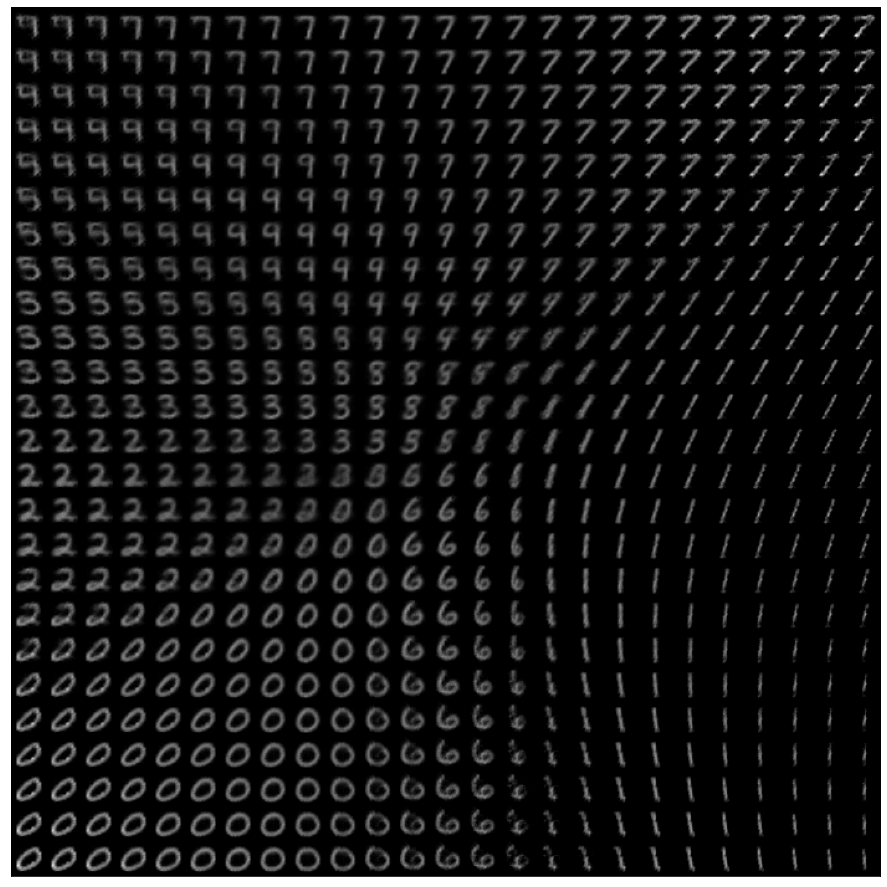

In [45]:
plt.figure(figsize=(16,16))
plt.xticks(ticks=[])
plt.yticks(ticks=[])
plt.imshow(image, cmap="gray")
plt.savefig("images/Generated Images.png")
plt.show()
